# <center>Tweet analysis with fastai

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *

In [4]:
import sys
import html
import json
import pandas as pd

## Directories

In [23]:
DATA_PATH = Path('C:/Users/G16116/Documents/Sentiment Analysis/Tweets/IEF')
WIKILM_PATH = Path('C:/Users/G16116/Documents/Python AUX/TweetSA/SpanishLM')
TWEETLM_PATH = DATA_PATH/'LM'
TWEETCLAS_PATH = DATA_PATH/'CLAS'

## Pre-process tweet dataset
Load the tweet database (all tweets, since the whole dataset is used for language model tuning)

In [6]:
tweets = np.array(pd.read_csv(DATA_PATH/'Tweets_IEF_limpios.csv')['text'])
tweets[:5]

array(['El banco dirigido por Shanwen Xin quiere fortalecer las relaciones con las empresas mexicanas para incrementar el negocio y la comunicación entre los países. https://t.co/8dBVvYAIDE',
       '#Entérate ¿Qué implicó la salida de Juan Díaz de la Torre de la SNTE? https://t.co/JMxMqfulDr',
       '“Las variables macroeconómicas que se han logrado en el país son muy fuertes en este momento, así que la perspectiva de algo similar a lo ocurrido en 1994 no la veo en el horizonte”: Serra Puche,  presidente del Consejo de Administración de BBVA Bancomer https://t.co/K2wbb3H5eO',
       'Lazarus, un grupo de hackers de Corea del Norte, quiso llevarse 100 millones de dólares del sistema financiero de @Banxico través de un ciberataque\r\n\r\nhttps://t.co/mA0ZOaaO8f',
       '¿Acabas de egresar de la universidad?👩\u200d🎓👨\u200d🎓Este banco está buscando tu talento:\r\nhttps://t.co/4jWbaGarcF'],
      dtype=object)

Pre-process tweets

In [7]:
import re

def clean_tweetNN(tweet):
    tweet = re.sub('http\S+', '_hyplink_', tweet) #Remove urls
    tweet = re.sub('RT @[\w_-]+',' ',tweet) #Remove RT text
    tweet = re.sub('@(?=[\w_-]+)','_user_ ',tweet) #Tag mentions
    tweet = re.sub(r'(\s\d+)', r' _num_\1', tweet)#(r'(\d+)', r'_num_ \1', tweet) #Tag numbers
    tweet = re.sub('#(?=[\w_-]+)', '_hashtag_ ', tweet) #Tag hastags
    tweet = tweet.split()
    c = ' '.join(tweet)
    return c

def clean_all(tweet_list):
    clean_tweets = [clean_tweetNN(line) for line in tweet_list]
    return clean_tweets
    

In [8]:
np.random.seed(42)
trn_idx = np.random.permutation(len(tweets))
tweets = tweets[trn_idx]

In [9]:
tweets = clean_all(tweets)
tweets[:5]

['Banxico destina _num_ 150 mdd a México por sismo del _num_ 7-S. _hyplink_',
 'Banorte baja costos y registra ganancias del _num_ 7% _hyplink_ _hashtag_ SiTeLoPerdiste',
 'A pesar de que el peso se recuperó tras el debate presidencial en EUA, el Banco de México no se confía. _hyplink_ _hyplink_',
 '_hashtag_ QueNoSeTePase Agustín Carstens presenta su renuncia al Banco de México _hyplink_ _hyplink_',
 '_user_ checolon Hola Sergio, por el momento Banorte, Banamex y Bancomer tienes ofertas similares en banca móvil. Saludos']

Build clean dataframe

In [24]:
df = pd.DataFrame({'label': 0, 'text': tweets})
df.head(5)

,label,text
0,0,Banxico destina _num_ 150 mdd a México por sis...
1,0,Banorte baja costos y registra ganancias del _...
2,0,A pesar de que el peso se recuperó tras el deb...
3,0,_hashtag_ QueNoSeTePase Agustín Carstens prese...
4,0,"_user_ checolon Hola Sergio, por el momento Ba..."


In [25]:
df.to_csv(TWEETLM_PATH/'tweets.csv', index = False)

Create TextDataBunch

In [26]:
tokenizer = Tokenizer(lang = 'es', n_cpus = 1, special_cases = ['_user_', '_hashtag_', '_num_', '_hyplink_'])
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=60000)]
                               
data_lm = (TextList.from_csv(TWEETLM_PATH, 'tweets.csv', cols='text', processor = processor)
                   .split_by_rand_pct(seed = 0)
                   .label_for_lm()
                   .databunch())

In [51]:
data_lm.save('data_lm0.pkl')

In [ ]:
data_lm = load_data(TWEETLM_PATH, 'data_lm0.pkl')

In [27]:
data_lm.show_batch(5)

idx,text
0,"renuncia al xxmaj banco de xxmaj méxico _hyplink_ _hyplink_ xxbos _user_ xxunk xxmaj hola xxmaj sergio , por el momento xxmaj banorte , xxmaj banamex y xxmaj bancomer tienes ofertas xxunk en banca móvil . xxmaj saludos xxbos _hashtag_ estirayafloja | xxmaj otro xxunk para xxmaj banamex en el caso de xxmaj pemex , escribe xxmaj jesús xxmaj rangel _hyplink_ _hyplink_ xxbos xxmaj ni el xxup tlcan ni las"
1,"miedo ... _hyplink_ _hyplink_ xxbos xxmaj positiva , la inyección de capital en xxup hsbc xxmaj méxico : xxmaj fitch _hyplink_ xxbos xxmaj se vende dólar menudeo en _num_ xxunk pesos : xxmaj el dólar cotiza a la compra , en xxmaj banamex , a _num_ xxunk y se vende a _num_ xxunk pesos , ... _hyplink_ xxbos xxmaj crece _num_ 7.0 % captación bancaria en abril : xxmaj"
2,"satmx xxunk “ por error ” mil _num_ 123 mdp a _num_ 5 empresas y un banco , detecta la _user_ asf_mexico _hyplink_ _hyplink_ xxbos xxmaj en el primer semestre del año , xxup bbva - xxmaj bancomer detectó _num_ 25 mil fraudes por concepto de comercio electrónico que ocasionarían pérdida a sus clientes _hyplink_ _hyplink_ xxbos xxmaj bajan perspectiva a banca mexicana _hyplink_ xxbos xxmaj scotiabank espera que"
3,"historia en xxmaj méxico . _hyplink_ xxbos xxmaj empresas mexicanas , las más optimistas con xxup tlcan : _user_ xxup hsbc _hyplink_ _hyplink_ xxbos xxup bbva xxmaj bancomer también se pone optimista con el crecimiento económico de xxmaj méxico > > _hyplink_ xxbos xxmaj indebida xxunk del _user_ xxup satmx a un banco y _num_ 4 empresas : _user_ asf_mexico _hyplink_ xxbos xxmaj acá todo xxmaj lo que debes"
4,en el país afectaría industria xxunk _hyplink_ _hyplink_ xxbos xxmaj alerta _user_ condusefmx a usuarios de la banca sobre correo falso de xxup bbva xxmaj bancomer _hyplink_ _hashtag_ siteloperdiste xxbos xxmaj la xxmaj asociación de xxmaj bancos de xxmaj méxico aseguró que los retrasos que se han presentado en el xxup spei no han afectado a todo el sistema ni a todos sus clientes . _hyplink_ xxbos xxmaj la


In [28]:
itos = data_lm.vocab.itos
print(itos[:30])

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '_hyplink_', 'de', 'en', '_hashtag_', ',', '_num_', 'la', 'el', 'a', 'méxico', '.', '_user_', 'y', ':', 'que', 'por', 'banco', 'del', 'para', 'banamex', 'los']


In [ ]:
pickle.dump(itos, open(TWEETLM_PATH/'itos0.pkl', 'wb'))

## Load encoder weights for language model

In [34]:
BACKBONE_MODEL = WIKILM_PATH/'lm1_weights_kl.h5'
BACKBONE_ITOS = WIKILM_PATH/'itos+100.pkl'

In [38]:
def convert(path_to_old_model, path_to_save_converted_model):
    old_wgts = torch.load(path_to_old_model, map_location=lambda storage, loc: storage)
    new_wgts = OrderedDict()
    new_wgts['0.encoder.weight']=old_wgts['0.encoder.weight']
    new_wgts['0.encoder_dp.emb.weight']=old_wgts['0.encoder_with_dropout.embed.weight']
    new_wgts['0.rnns.0.weight_hh_l0_raw']=old_wgts['0.rnns.0.module.weight_hh_l0_raw']
    new_wgts['0.rnns.0.module.weight_ih_l0']=old_wgts['0.rnns.0.module.weight_ih_l0']
    new_wgts['0.rnns.0.module.weight_hh_l0']=old_wgts['0.rnns.0.module.weight_hh_l0_raw']
    new_wgts['0.rnns.0.module.bias_ih_l0']=old_wgts['0.rnns.0.module.bias_ih_l0']
    new_wgts['0.rnns.0.module.bias_hh_l0']=old_wgts['0.rnns.0.module.bias_hh_l0']
    new_wgts['0.rnns.1.weight_hh_l0_raw']=old_wgts['0.rnns.1.module.weight_hh_l0_raw']
    new_wgts['0.rnns.1.module.weight_ih_l0']=old_wgts['0.rnns.1.module.weight_ih_l0']
    new_wgts['0.rnns.1.module.weight_hh_l0']=old_wgts['0.rnns.1.module.weight_hh_l0_raw']
    new_wgts['0.rnns.1.module.bias_ih_l0']=old_wgts['0.rnns.1.module.bias_ih_l0']
    new_wgts['0.rnns.1.module.bias_hh_l0']=old_wgts['0.rnns.1.module.bias_hh_l0']
    new_wgts['0.rnns.2.weight_hh_l0_raw']=old_wgts['0.rnns.2.module.weight_hh_l0_raw']
    new_wgts['0.rnns.2.module.weight_ih_l0']=old_wgts['0.rnns.2.module.weight_ih_l0']
    new_wgts['0.rnns.2.module.weight_hh_l0']=old_wgts['0.rnns.2.module.weight_hh_l0_raw']
    new_wgts['0.rnns.2.module.bias_ih_l0']=old_wgts['0.rnns.2.module.bias_ih_l0']
    new_wgts['0.rnns.2.module.bias_hh_l0']=old_wgts['0.rnns.2.module.bias_hh_l0']
    new_wgts['1.decoder.bias'] = torch.rand(60002)
    torch.save(new_wgts, path_to_save_converted_model/'converted_model.pth')

In [39]:
convert(BACKBONE_MODEL,  WIKILM_PATH)

In [40]:
BACKBONE_MODEL = WIKILM_PATH/'converted_model.pth'

## Language Model

In [42]:
bs=32

In [ ]:
data_lm = load_data(TWEETLM_PATH, 'data_lm.pkl', bs=bs)

In [46]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained = False)
learn.load_pretrained(BACKBONE_MODEL, BACKBONE_ITOS)

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


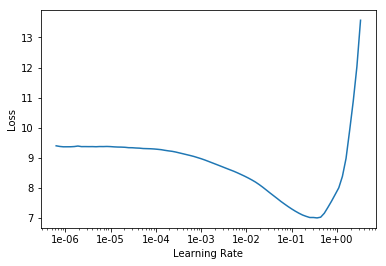

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.565911,2.900839,0.419252,30:57


In [50]:
learn.save('fit_head0')

In [ ]:
learn.load('fit_head0');

To complete the fine-tuning, we can then unfreeze and launch a new training

In [52]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.729928,2.856113,0.424172,30:55
1,2.661071,2.767385,0.436830,30:05
2,2.530057,2.662045,0.453981,31:18


In [ ]:
learn.save('fine_tuned0')

In [ ]:
learn.save_encoder('fine_tuned_enc0')

## Classifier

In [ ]:
tweets = pd.read_csv(DATA_PATH/'validated_tweets_SB.csv')[['sent_control', 'text']]
tweets.columns = ['label', 'text']
tweets.head()

In [ ]:
tweets.to_csv(DATA_PATH/'CLAS'/'data_clas.csv', index = False)

In [ ]:
data_clas = (TextList.from_csv(DATA_PATH/'CLAS', 'data_clas.csv', cols='text', vocab=data_lm.train_ds.vocab, processor = processor)
                   .split_by_rand_pct(seed = 0)
                   .label_from_df(cols='label')
                   .databunch())

In [ ]:
data_clas.save('data_clas.pkl')

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained = False)
learn.load_encoder(TWEETLM_PATH/'models'/'fine_tuned_enc')